In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [2]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood['content_last'] = mood.groupby('user_id')['content'].shift()
mood.loc[(pd.isnull(mood.content_last)), 'content_last'] = mood['content']
mood_content = mood.drop(["anxious", "bored", "cheerful", "user_id", "response_time"], axis=1)

In [3]:
# Normalize predictors
mood_normz = mood_content.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [4]:
# X = predictors, y = target
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]

# Convert float to int
y = y.astype(int)

In [5]:
# Train (80%) & Test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [6]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['content'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['content'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 

Before OverSampling, counts of labels: 3    3165
4    2379
2    2203
1    1261
0     872
5     696
Name: content, dtype: int64
After OverSampling, counts of label '0': 3165
After OverSampling, counts of label '1': 3165
After OverSampling, counts of label '2': 3165
After OverSampling, counts of label '3': 3165
After OverSampling, counts of label '4': 3165
After OverSampling, counts of label '5': 3165


In [7]:
# Convert oversample dataset to Pandas DataFrame
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res, columns=['content'])

In [8]:
# Frank & hall encoding

def multiple_appends(listname, *element):
    listname.extend(element)

y_trainFH = []
for index, row in y_train.iterrows():
    frankhalltrain = []
    if row['content'] == 0:
        multiple_appends(frankhalltrain, 0, 0, 0, 0, 0)
    elif row['content'] == 1:
        multiple_appends(frankhalltrain, 1, 0, 0, 0, 0)
    elif row['content'] == 2:
        multiple_appends(frankhalltrain, 1, 1, 0, 0, 0)
    elif row['content'] == 3:
        multiple_appends(frankhalltrain, 1, 1, 1, 0, 0)
    elif row['content'] == 4:
        multiple_appends(frankhalltrain, 1, 1, 1, 1, 0)
    elif row['content'] == 5:
        multiple_appends(frankhalltrain, 1, 1, 1, 1, 1)
    y_trainFH.append(frankhalltrain)

In [9]:
# Convert oversample dataset to Pandas DataFrame
y_train = pd.DataFrame(data=y_trainFH)

In [10]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [11]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlycontentlast = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlycontentlast = X_test.iloc[:,-1:]

In [12]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 65        
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train model on train set
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 15192 samples, validate on 3798 samples
Epoch 1/100
15192/15192 [==============================] - 0s 17us/step - loss: 0.6648 - accuracy: 0.6717 - val_loss: 0.6410 - val_accuracy: 0.7025
Epoch 2/100
15192/15192 [==============================] - 0s 6us/step - loss: 0.6247 - accuracy: 0.6993 - val_loss: 0.6063 - val_accuracy: 0.7026
Epoch 3/100
15192/15192 [==============================] - 0s 7us/step - loss: 0.5978 - accuracy: 0.6994 - val_loss: 0.5869 - val_accuracy: 0.7026
Epoch 4/100
15192/15192 [==============================] - 0s 6us/step - loss: 0.5841 - accuracy: 0.6994 - val_loss: 0.5782 - val_accuracy: 0.7026
Epoch 5/100
15192/15192 [==============================] - 0s 6us/step - loss: 0.5782 - accuracy: 0.6987 - val_loss: 0.5749 - val_accuracy: 0.7024
Epoch 6/100
15192/15192 [==============================] - 0s 5us/step - loss: 0.5757 - accuracy: 0.6992 - val_loss: 0.5733 - val_accuracy: 0.7028
Epoch 7/100
15192/15192 [==============================] - 0s 5us/st

15192/15192 [==============================] - 0s 5us/step - loss: 0.5674 - accuracy: 0.7070 - val_loss: 0.5670 - val_accuracy: 0.7063
Epoch 57/100
15192/15192 [==============================] - 0s 5us/step - loss: 0.5673 - accuracy: 0.7069 - val_loss: 0.5667 - val_accuracy: 0.7089
Epoch 58/100
15192/15192 [==============================] - 0s 4us/step - loss: 0.5672 - accuracy: 0.7079 - val_loss: 0.5664 - val_accuracy: 0.7061
Epoch 59/100
15192/15192 [==============================] - 0s 5us/step - loss: 0.5672 - accuracy: 0.7073 - val_loss: 0.5667 - val_accuracy: 0.7053
Epoch 60/100
15192/15192 [==============================] - 0s 4us/step - loss: 0.5671 - accuracy: 0.7073 - val_loss: 0.5663 - val_accuracy: 0.7058
Epoch 61/100
15192/15192 [==============================] - 0s 5us/step - loss: 0.5672 - accuracy: 0.7070 - val_loss: 0.5662 - val_accuracy: 0.7058
Epoch 62/100
15192/15192 [==============================] - 0s 5us/step - loss: 0.5670 - accuracy: 0.7073 - val_loss: 0.5661 

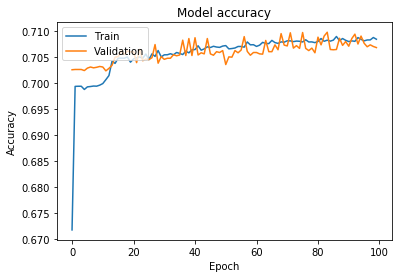

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

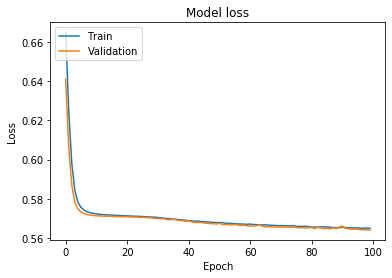

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Predict using X_test
y_pred = model.predict(X_test_nomood)

FH_pred = []
for i in y_pred:
    temp_list = []
    for binary in i:
        if binary >= 0.5:
            temp_list.append(1)
        else:
            temp_list.append(0)
    FH_pred.append(temp_list)

FH_prediction = pd.DataFrame(data=FH_pred, columns=['mood_0', 'mood_1', 'mood_2', 'mood_3', 'mood_4'])

In [17]:
# All unique outcomes
check_pos = []
for ac in FH_pred:
    if ac not in check_pos:
        check_pos.append(ac)
print(check_pos)

[[1, 1, 1, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 1, 1, 0], [1, 1, 1, 0, 1]]


In [18]:
pred = FH_prediction.sum(axis=1)
test = y_test['content'].values

In [19]:
pred.value_counts()

2    1631
3     985
4      18
1      11
dtype: int64

In [20]:
y_test['content'].unique()

array([2, 1, 3, 4, 0, 5])

In [21]:
X_test_onlycontentlast[:5]

,content_last
13312,0.0
11229,2.0
10034,2.0
11327,3.0
6715,1.0


In [22]:
# Accuracy score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 25.482041587901698


In [23]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_content = X_test_onlycontentlast['content_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_content[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_content[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_content[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_content[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
print("")
print("Accuracy of table is: ", ((same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong)))
print("Accuracy of model is: ", a)

        Same Dif
correct 416 258
wrong   1245 726

Accuracy of table is:  0.254820415879017
Accuracy of model is:  0.254820415879017


In [24]:
from collections import Counter
print("Predicted values: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_content))

Predicted values:  Counter({2: 1631, 3: 985, 4: 18, 1: 11})
True values:  Counter({3: 807, 4: 579, 2: 572, 1: 298, 0: 218, 5: 171})
Previous mood: Counter({3.0: 786, 4.0: 590, 2.0: 576, 1.0: 294, 0.0: 215, 5.0: 184})


In [25]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_content[i]:
            same_correct_0 += 1
        if test[i] != X_test_content[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_content[i]:
            same_wrong_0 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_0 += 1

    if test[i] == 1 and pred[i] == 1:
        if test[i] == X_test_content[i]:
            same_correct_1 += 1
        if test[i] != X_test_content[i]:
            dif_correct_1 += 1
    if test[i] == 1 and pred[i] != 1:
        if test[i] == X_test_content[i]:
            same_wrong_1 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_1 += 1
        
    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_content[i]:
            same_correct_2 += 1
        if test[i] != X_test_content[i]:
            dif_correct_2 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_content[i]:
            same_wrong_2 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_2 += 1
    
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_content[i]:
            same_correct_3 += 1
        if test[i] != X_test_content[i]:
            dif_correct_3 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_content[i]:
            same_wrong_3 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_3 += 1
        
    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_content[i]:
            same_correct_4 += 1
        if test[i] != X_test_content[i]:
            dif_correct_4 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_content[i]:
            same_wrong_4 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_4 += 1
    
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_content[i]:
            same_correct_5 += 1
        if test[i] != X_test_content[i]:
            dif_correct_5 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_content[i]:
            same_wrong_5 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_content))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  0
Same Wrong 0 guesses is:  151
Dif Correct 0 guesses is:  0
Dif Wrong 0 guesses is:  67

Same Correct 1 guesses is:  2
Same Wrong 1 guesses is:  157
Dif Correct 1 guesses is:  1
Dif Wrong 1 guesses is:  138

Same Correct 2 guesses is:  217
Same Wrong 2 guesses is:  128
Dif Correct 2 guesses is:  137
Dif Wrong 2 guesses is:  90

Same Correct 3 guesses is:  194
Same Wrong 3 guesses is:  313
Dif Correct 3 guesses is:  119
Dif Wrong 3 guesses is:  181

Same Correct 4 guesses is:  3
Same Wrong 4 guesses is:  385
Dif Correct 4 guesses is:  1
Dif Wrong 4 guesses is:  190

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  111
Dif Correct 5 guesses is:  0
Dif Wrong 5 guesses is:  60


In [26]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 1 and pred[i] != 1:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 1:
        cnt_1 += 1
    if test[z] == 2:
        cnt_2 += 1
    if test[z] == 3:
        cnt_3 += 1
    if test[z] == 4:
        cnt_4 += 1
    if test[z] == 5:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [27]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  1.4626
Macro-averaged F1-score is:  0.1812


/Users/Stijn/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
